# Anchor Vector Optimization

In [25]:
import gensim
import numpy as np
import scipy
import tensorflow as tf

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

In [10]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [2]:
anchor_words = ['travel', 'hotel', 'resort', 'airfare', 'cruise', 'plane', 'vacation', 'train', 'inn', 'Hilton']
anchor_vecs = [model.get_vector(w) for w in anchor_words]

travel_words = ['hilton', 'inns', 'suites', 'Marriott', 'courtyard', 'Hilton', 'Westin', 'Comfort_Suites', 'Double_Tree']
bad_words = ['potato', 'target', 'walmart', 'walk', 'industrial', 'mechanical', 'fresh', 'phone', 'discover', 
             'pinata', 'save', 'nooshi', 'capitol', 'smash', 'burger', 'chase']

hilton = model.get_vector('hilton')
hilton_dist = model.distance('hilton', 'pinata')
hilton_dist

NameError: name 'model' is not defined

In [3]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

anchors = [
    np.array([0.10, 0.20]),
    np.array([0.33, 0.81]),
    np.array([0.67, 0.52]),
    np.array([0.60, 0.84])
]

dist = lambda a, b: np.linalg.norm(a - b)

def f(x, y, anchors, p=2, q=1):
    
    result = 1
    for a in anchors:
        norm = ((x - a[0])**p + (y - a[1])**p)**(1/p)
        result *= norm
    
    result ** 2
    
    return (1 - result)**q

def sigmoid(x, w = 1, b = 0):
    
    s = 1 / (1 + np.exp(-x * w + b))
    return s

<IPython.core.display.Javascript object>


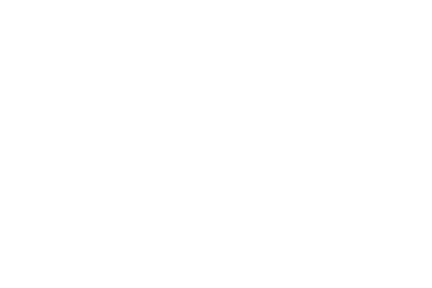

Text(0.5,0,'z')

<IPython.core.display.Javascript object>


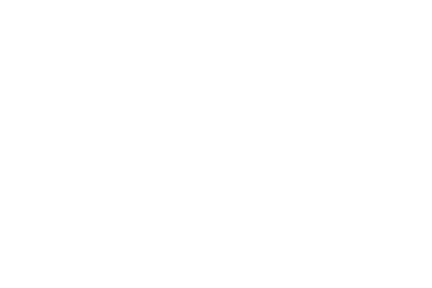

In [39]:
%matplotlib notebook

Z = f(X, Y, anchors, q=1)
Z = sigmoid(Z, 1, 0)

fig = plt.figure()
ax = Axes3D(fig)
ax.contour3D(X, Y, Z, 50, cmap = 'coolwarm')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

<IPython.core.display.Javascript object>


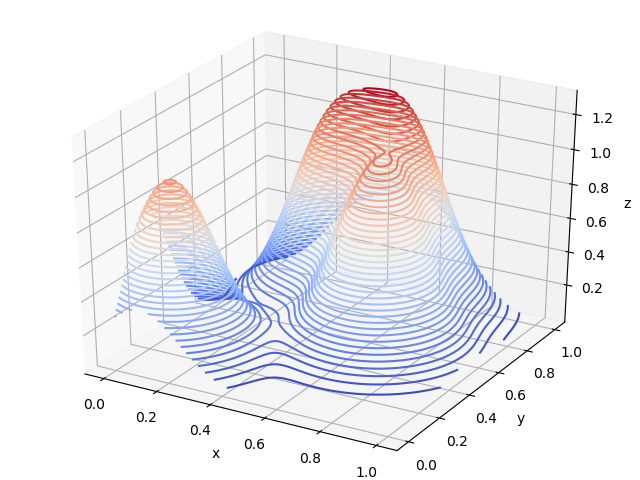

Text(0.5,0,'z')

In [9]:
def gauss_kernel(x, y, anchors, c = 1):
    result = 0
    for a in anchors:
        result += np.exp((-((x - a[0])/c)**2 - ((y - a[1])/c)**2))
    return result

%matplotlib notebook

Z_gauss = gauss_kernel(X, Y, anchors, c = 0.2)

fig = plt.figure()
ax = Axes3D(fig)
ax.contour3D(X, Y, Z_gauss, 50, cmap = 'coolwarm')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [560]:
cart_to_sphere(*sphere_to_cart(1, np.pi/2, 3/2*np.pi))

(1.0, 1.5707963267948966, -1.5707963267948968)

In [ ]:
def get_norm(A, data):
    
    A_norm = np.atleast_2d(np.linalg.norm(A, axis = 0)).T
    data_norm = np.atleast_2d(np.linalg.norm(data, axis = 0))
    norm = np.dot(A_norm, data_norm)
    
    return norm

def get_cos_dist(A, data):
    
    norm = get_norm(A, data)
    sim = np.dot(A.T, data)/norm
    dist = 1 - sim
    
    return dist

# Multiplicative Distance
get_D = lambda dist: np.prod(dist, axis = 0)
    
# Sigmoid
sigmoid = lambda x: 1/(1 + np.exp(-x))

# --------------------------- #

# Choose 4 random points from training set to initialize anchors
indices = np.array([i for i in range(len(X))])
np.random.shuffle(indices)
ix_rand = indices[:4]

# Initialize parameters
A_0 = np.array([X[ix_rand], Y[ix_rand], Z[ix_rand]])
w_0 = 0
b_0 = 0

A = A_0 # shape = (3, 4)
w = w_0
b = b_0
data = np.array([X, Y, Z]) # shape = (3, 200)

D = get_D(get_cos_dist(A, data))
prob = sigmoid(D * w + b)

# Generate Data

In [4]:
x_data = np.random.randn(500)
y_data = np.random.randn(500)
z_data = np.random.randn()

def sphere_to_cart(r, theta, phi):

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi) 
    z = r * np.cos(theta) 
    
    return x, y, z

def cart_to_sphere(x, y, z):
    
    r = (x**2 + y**2 + z**2)**0.5
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    
    return r, theta, phi

def rand_points(num = 50, mu = 0, sigma = 1):
    
    return np.random.randn(num) * sigma - mu

def rand_points_unif(num = 50, mu = [0, 0, 0], sigma = 0.2):
    
    x_1 = np.random.randn(num) * sigma - mu[0]
    x_2 = np.random.randn(num) * sigma - mu[1]
    x_3 = np.random.randn(num) * sigma - mu[2]
    
    return x_1, x_2, x_3

x = {}
y = {}
z = {}

x[1] = rand_points(mu = 1.2, sigma = 0.3)
y[1] = rand_points(mu = 1.4, sigma = 0.4)
z[1] = rand_points(mu = 0.9, sigma = 0.2)

x[2] = rand_points(mu = 1.5, sigma = 0.3)
y[2] = rand_points(mu = 0.2, sigma = 0.2)
z[2] = rand_points(mu = -0.7, sigma = 0.3)

x[3] = rand_points(mu = 0.6, sigma = 0.2)
y[3] = rand_points(mu = 1.3, sigma = 0.2)
z[3] = rand_points(mu = 0.8, sigma = 0.6)

x[4] = rand_points(mu = -0.2, sigma = 0.3)
y[4] = rand_points(mu = -0.6, sigma = 0.2)
z[4] = rand_points(mu = 1.2, sigma = 0.5)

X_pos = np.concatenate([x[1], x[2], x[3], x[4]])
Y_pos = np.concatenate([y[1], y[2], y[3], y[4]])
Z_pos = np.concatenate([z[1], z[2], z[3], z[4]])

x[5], y[5], z[5] = sphere_to_cart(*rand_points_unif(mu = [1, -1, 1], sigma = 0.2))
x[6], y[6], z[6] = sphere_to_cart(*rand_points_unif(mu = [1, 2, 2], sigma = 0.4))
x[7], y[7], z[7] = sphere_to_cart(*rand_points_unif(mu = [1, 2.7, -2], sigma = 0.5))
x[8], y[8], z[8] = sphere_to_cart(*rand_points_unif(mu = [1, 2, 0.5], sigma = 0.5))

X_neg = np.concatenate([x[5], x[6], x[7], x[8]])
Y_neg = np.concatenate([y[5], y[6], y[7], y[8]])
Z_neg = np.concatenate([z[5], z[6], z[7], z[8]])

r_pos, theta_pos, phi_pos = cart_to_sphere(X_pos, Y_pos, Z_pos)
r_neg, theta_neg, phi_neg = cart_to_sphere(X_neg, Y_neg, Z_neg)

data_pos = np.array([X_pos, Y_pos, Z_pos])
data_neg = np.array([X_neg, Y_neg, Z_neg])
labels_pos = np.ones((1, data_pos.shape[1]))
labels_neg = np.zeros((1, data_pos.shape[1]))

data = np.concatenate([data_pos, data_neg], axis = 1)
labels = np.concatenate([labels_pos, labels_neg], axis = 1)

m = data.shape[1]
indices = np.array([i for i in range(m)])
np.random.shuffle(indices)

m_train = int(0.8 * m)
m_test = m - m_train

ix_train = indices[:m_train]
ix_test = indices[m_train:]

X_train = data[:, ix_train]
X_test = data[:, ix_test]

Y_train = labels[:, ix_train]
Y_test = labels[:, ix_test]

# Visualize Data

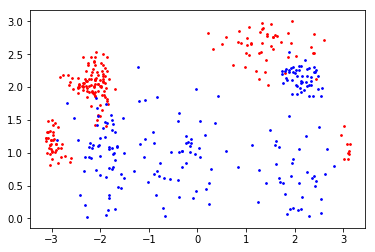

In [5]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax = Axes3D(fig)
# ax.scatter(X, Y, Z)
ax.scatter(phi_pos, theta_pos, c = 'red', s = 3)
ax.scatter(phi_neg, theta_neg, c = 'blue', s = 3)

# Set up Model

In [6]:
def create_placeholders(n_x, n_y):
    
    X = tf.placeholder(tf.float32, shape = [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = "Y")
    
    return X, Y

def initialize_params(k, n_x):
    
    # k anchors
    # n features
    
    A = tf.get_variable("A", [k, n_x], dtype = tf.float32, initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    w = tf.get_variable("w", [1], dtype = tf.float32, initializer = tf.zeros_initializer())
    b = tf.get_variable("b", [1], dtype = tf.float32, initializer = tf.zeros_initializer())
    
    params = {
        "A": A,
        "w": w,
        "b": b
    }
                        
    return params

def forward_propagate(X, params):

    # X.shape = (n, m)
    # A.shape = (k, n)
    
    A = params["A"]
    w = params["w"]
    b = params["b"]
    
    Z = tf.matmul(A, X)
    norm_A0 = tf.norm(A, axis = 1)
    norm_A1 = tf.reshape(norm_A0, (tf.shape(norm_A0)[0], 1))
    norm_X0 = tf.norm(X, axis = 0)
    norm_X1 = tf.reshape(norm_X0, (1, tf.shape(norm_X0)[0]))
    norm = tf.matmul(norm_A1, norm_X1)
    sim = tf.divide(Z, norm) # shape = (k, m)
    dist = 1 - sim
    D = tf.reduce_prod(dist, axis = 0) # shape = (1, m)
    H = tf.sigmoid(w * D + b)
    
    return H

def get_cost(Y, H):
    
    # Y.shape = (1, m)
    # D.shape = (1, m)
    
    m = tf.cast(tf.shape(Y)[1], dtype = "float32")
    cost = - 1 / m * tf.reduce_sum((Y * tf.log(H) + (1 - Y) * tf.log(1 - H)))
    
    return cost



def random_mini_batches(X_train, Y_train, minibatch_size, seed):
    
    np.random.seed(seed)
    (n, m) = X_train.shape
    indices = np.array([i for i in range(n)])
    np.random.shuffle(indices)
    
    minibatches = []
    i = 0
    
    while i < m:
        
        minibatches.append((X_train[:, i:i+minibatch_size], Y_train[:, i:i+minibatch_size]))
        i += minibatch_size
    
    return minibatches

def model(X_train, 
          Y_train, 
          X_test, 
          Y_test, 
          k = 4,
          learning_rate = 0.0001,
          num_epochs = 1500, 
          minibatch_size = 32, 
          print_cost = True):
    
    # X_train.shape = (n_x, m)
    # Y_train.shape = (1, m)
    
    tf.reset_default_graph()
    
    tf.set_random_seed(1)
    seed = 2
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    params = initialize_params(k, n_x)
    H = forward_propagate(X, params)
    cost = get_cost(Y, H)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            
            if print_cost == True and epoch % 200 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        params = sess.run(params)
        print("Training complete.")
        
        pred = sess.run(H, feed_dict = {X: X_test})
        
        return pred, params

# Run Model

Cost after epoch 0: 0.692529
Cost after epoch 200: 0.428797
Cost after epoch 400: 0.414100
Cost after epoch 600: 0.340362
Cost after epoch 800: 0.263911
Cost after epoch 1000: 0.227324
Cost after epoch 1200: 0.202180
Cost after epoch 1400: 0.184040
Cost after epoch 1600: 0.170983
Cost after epoch 1800: 0.161765
Cost after epoch 2000: 0.155386
Cost after epoch 2200: 0.151021
Cost after epoch 2400: 0.148004
Cost after epoch 2600: 0.145800
Cost after epoch 2800: 0.143732
Cost after epoch 3000: 0.137787
Cost after epoch 3200: 0.128969
Cost after epoch 3400: 0.124526
Cost after epoch 3600: 0.122731
Cost after epoch 3800: 0.121413
Cost after epoch 4000: 0.120326
Cost after epoch 4200: 0.119412
Cost after epoch 4400: 0.118636
Cost after epoch 4600: 0.117972
Cost after epoch 4800: 0.117400


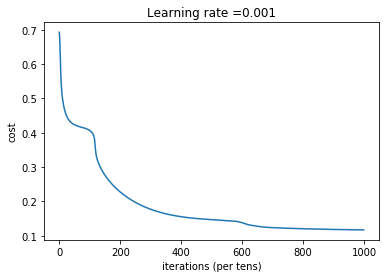

Training complete.


In [60]:
pred, params = model(X_train, 
                     Y_train, 
                     X_test, 
                     Y_test, 
                     k = 4, 
                     learning_rate = 0.001,
                     num_epochs = 5000)

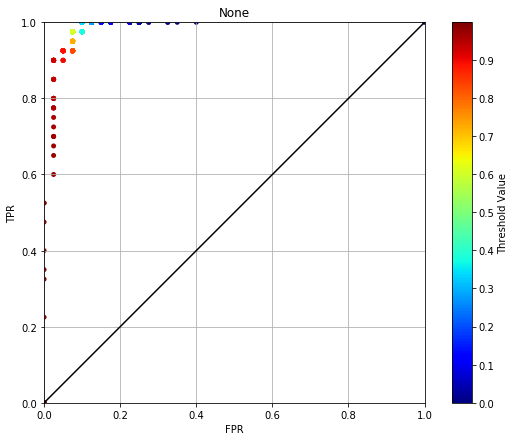

In [61]:
fpr, tpr, thresh = roc_curve(Y_test.flatten().tolist(), pred.flatten().tolist())

def predict(probs, thresh=0.5):
    predictions = (probs > thresh).astype(int)
    return predictions
  
def get_tpr_and_fpr(predictions, ground_truth, pos, neg):
    
    predictions = predictions.flatten()
    groud_truth = ground_truth.flatten()
    tpr = np.sum(np.logical_and(predictions == 1, ground_truth == 1))/pos
    fpr = np.sum(np.logical_and(predictions == 1, ground_truth == 0))/neg
    return tpr, fpr

def get_roc(probabilities, y, thresh_values):

    y = np.array(y)
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)

    roc_tpr = []
    roc_fpr = []

    for v in thresh_values:
        predictions = predict(probabilities, v)
        tpr, fpr = get_tpr_and_fpr(predictions, y, pos, neg)
        roc_tpr.append(tpr)
        roc_fpr.append(fpr)

    roc = {
        "tpr" : roc_tpr,
        "fpr" : roc_fpr,
    }
  
    return roc

def plot_roc(y, probs, N=500, title=None):
  
    N = N
    thresh_values = np.arange(N)/N

    roc = get_roc(probs, y, thresh_values)

    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(1, 1, 1, aspect = "equal")
    ax.grid(True)

    ax.scatter(roc["fpr"], 
           roc["tpr"], 
           s = 100, 
           c = thresh_values, 
           cmap = "jet",
           marker = '.', 
           edgecolors = 'none')

    ax.plot([0, 1], [0, 1], 'k-')
    norm = matplotlib.colors.Normalize(thresh_values[0], thresh_values[-1])
    sm = plt.cm.ScalarMappable(norm=norm, cmap = "jet")
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=np.linspace(0, 1, 11))
    cbar.set_label("Threshold Value")

    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    display(fig)
    plt.gcf().clear()

    return roc

roc = plot_roc(Y_test, pred)

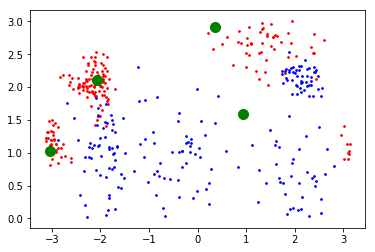

In [62]:
%matplotlib inline

A_learned = params["A"]

A_r, A_theta, A_phi = cart_to_sphere(A_learned[:, 0], A_learned[:, 1], A_learned[:, 2])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(phi_pos, theta_pos, c = 'red', s = 3)
ax.scatter(phi_neg, theta_neg, c = 'blue', s = 3)
ax.scatter(A_phi, A_theta, c = 'green', s = 100)

In [295]:
A_learned

array([[-0.29652452, -0.87305176, -0.8913188 ],
       [-0.34752998, -0.01504137,  0.1889065 ],
       [ 0.57741255,  0.41741344, -0.19353569],
       [ 0.13701116, -0.14719032, -0.38311696]], dtype=float32)

Text(0,0.5,'theta')

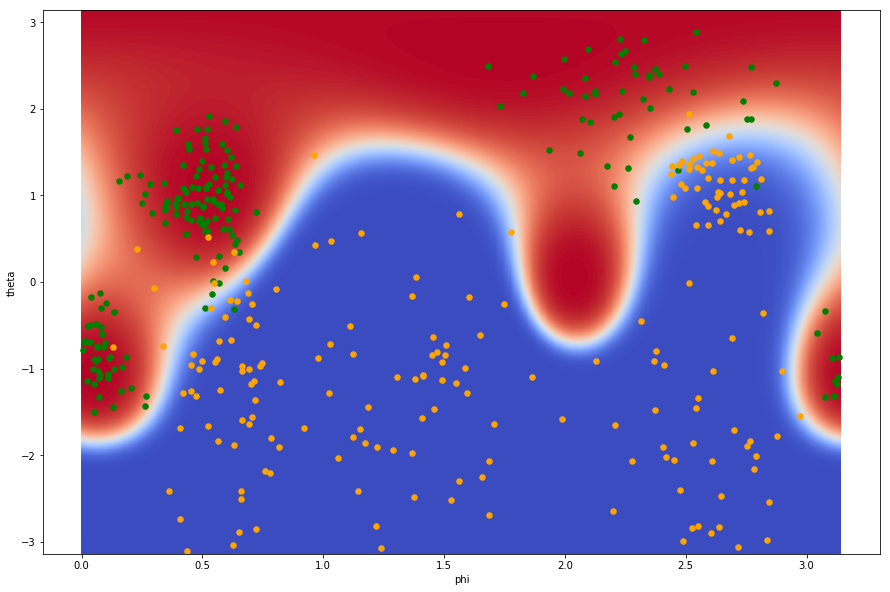

In [63]:
%matplotlib inline

phi = np.linspace(-np.pi, np.pi, 100)
theta = np.linspace(0, np.pi, 100)
Phi, Theta = np.meshgrid(phi, theta)

anchors = [np.array(k) for k in np.array([A_phi, A_theta]).T.tolist()]

def get_ang_cos_sim(A_phi, A_theta, phi, theta):
    
    sim = []
    
    for i in range(len(A_phi)):
        
        # (phi x theta)
        
        s = np.sin(A_theta[i]) \
            * np.dot(np.atleast_2d(np.cos(A_phi[i] - phi)).T, np.atleast_2d(np.sin(theta))) \
            + np.cos(A_theta[i]) * np.cos(np.atleast_2d(theta))

        sim.append(s)
    
    return np.array(sim)

# Multiplicative Distance
get_D = lambda dist: np.prod(dist, axis = 0)  

sim = get_ang_cos_sim(A_phi, A_theta, phi, theta)
dist = 1 - sim
D = get_D(dist) ** 1
D = sigmoid(params["w"] * D + params["b"], 1, 0)

D.shape

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1, 1, 1)
# ax = Axes3D(fig)
ax.contourf(Theta, Phi, D, 1000, cmap = 'coolwarm')
ax.scatter((phi_pos + np.pi)/2, (theta_pos * 2) - np.pi, c = 'green', s = 30)
ax.scatter((phi_neg + np.pi)/2, (theta_neg * 2) - np.pi, c = 'orange', s = 30)
ax.set_xlabel("phi")
ax.set_ylabel("theta")

In [30]:
theta

array([0.        , 0.03173326, 0.06346652, 0.09519978, 0.12693304,
       0.1586663 , 0.19039955, 0.22213281, 0.25386607, 0.28559933,
       0.31733259, 0.34906585, 0.38079911, 0.41253237, 0.44426563,
       0.47599889, 0.50773215, 0.53946541, 0.57119866, 0.60293192,
       0.63466518, 0.66639844, 0.6981317 , 0.72986496, 0.76159822,
       0.79333148, 0.82506474, 0.856798  , 0.88853126, 0.92026451,
       0.95199777, 0.98373103, 1.01546429, 1.04719755, 1.07893081,
       1.11066407, 1.14239733, 1.17413059, 1.20586385, 1.23759711,
       1.26933037, 1.30106362, 1.33279688, 1.36453014, 1.3962634 ,
       1.42799666, 1.45972992, 1.49146318, 1.52319644, 1.5549297 ,
       1.58666296, 1.61839622, 1.65012947, 1.68186273, 1.71359599,
       1.74532925, 1.77706251, 1.80879577, 1.84052903, 1.87226229,
       1.90399555, 1.93572881, 1.96746207, 1.99919533, 2.03092858,
       2.06266184, 2.0943951 , 2.12612836, 2.15786162, 2.18959488,
       2.22132814, 2.2530614 , 2.28479466, 2.31652792, 2.34826

In [345]:
np.sin(A_theta[0]) * np.dot(np.atleast_2d(np.cos(A_phi[0] - phi)).T, np.atleast_2d(np.sin(theta)))

array([[0.00000000e+00, 7.33622915e-03, 1.46650713e-02, ...,
        1.46650713e-02, 7.33622915e-03, 2.83166553e-17],
       [0.00000000e+00, 8.69141080e-03, 1.73740701e-02, ...,
        1.73740701e-02, 8.69141080e-03, 3.35474367e-17],
       [0.00000000e+00, 1.00115952e-02, 2.00131096e-02, ...,
        2.00131096e-02, 1.00115952e-02, 3.86431345e-17],
       ...,
       [0.00000000e+00, 4.54282043e-03, 9.08106663e-03, ...,
        9.08106663e-03, 4.54282043e-03, 1.75345504e-17],
       [0.00000000e+00, 5.95150710e-03, 1.18970215e-02, ...,
        1.18970215e-02, 5.95150710e-03, 2.29718526e-17],
       [0.00000000e+00, 7.33622915e-03, 1.46650713e-02, ...,
        1.46650713e-02, 7.33622915e-03, 2.83166553e-17]])

# Debug

In [180]:
n_x = X_train.shape[0]
n_y = Y_train.shape[0]
k = 4

tf.reset_default_graph()

def get_cost(Y, H):
    m = tf.cast(tf.shape(Y)[1], dtype = "float32")
    cost = - 1 / m * tf.reduce_sum((Y * tf.log(H) + (1 - Y) * tf.log(1 - H)))
    return cost

X, Y = create_placeholders(n_x, n_y)
params = initialize_params(k, n_x)
H = forward_propagate(X, params)
cost = get_cost(Y, H)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    p_results = sess.run(cost, feed_dict = {X: X_train, Y: Y_train})
    
p_results

0.6931468